## Differential abundance with Milo

In [1]:
suppressPackageStartupMessages(
{library(SingleCellExperiment)
library(biomaRt)
library(data.table)
library(scater)
library(BiocParallel)
library(scran)
library(miloR)
}
)

In [2]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("miloR")

### 1. Load RDS object 

In [3]:
human_dir <- "/nfs/team292/vl6/FetalReproductiveTract/"

In [4]:
sce <- readRDS(paste0(human_dir, "organoids_BPA_g1.rds"))
sce

class: SingleCellExperiment 
dim: 17390 29307 
metadata(1): log1p
assays(3): X raw_counts log_normalised_counts
rownames(17390): A1BG A1BG-AS1 ... ZZEF1 hsa-mir-423
rowData names(67): GeneID.0 GeneName.0 ... n_cells.9 n_cells
colnames(29307): HD_F_GON15290542_TAGCCGGCAGTCAGCC
  HD_F_GON15290542_TGGGCGTTCCAAACTG ...
  HD_F_GON15290559_TATCTCATCATGTCCC HD_F_GON15290559_GGGAGATTCTACGAGT
colData names(18): n_counts n_genes ... leiden celltype
reducedDimNames(3): PCA UMAP X_pca_harmony
mainExpName: NULL
altExpNames(0):

In [5]:
levels(sce$condition)

[1] "BPA"       "ctrl_dmso"

In [6]:
sce$condition <- factor(sce$condition, levels = c("ctrl_dmso", "BPA"))
levels(sce$condition)

[1] "ctrl_dmso" "BPA"

### 2. Format the SCE object with appropriate slots for raw and normalised counts

In [7]:
assay(sce, "counts") <- assay(sce, "raw_counts")
assay(sce, "logcounts") <- assay(sce, "log_normalised_counts")

In [8]:
sce

class: SingleCellExperiment 
dim: 17390 29307 
metadata(1): log1p
assays(5): X raw_counts log_normalised_counts counts logcounts
rownames(17390): A1BG A1BG-AS1 ... ZZEF1 hsa-mir-423
rowData names(67): GeneID.0 GeneName.0 ... n_cells.9 n_cells
colnames(29307): HD_F_GON15290542_TAGCCGGCAGTCAGCC
  HD_F_GON15290542_TGGGCGTTCCAAACTG ...
  HD_F_GON15290559_TATCTCATCATGTCCC HD_F_GON15290559_GGGAGATTCTACGAGT
colData names(18): n_counts n_genes ... leiden celltype
reducedDimNames(3): PCA UMAP X_pca_harmony
mainExpName: NULL
altExpNames(0):

In [9]:
# Remove unnecessary assay slots 
assay(sce, "X") <- NULL
assay(sce, "raw_counts") <- NULL
assay(sce, "log_normalised_counts") <- NULL

### 3. Create Milo object on Harmony embedding

In [10]:
sce_milo <- Milo(sce)

In [11]:
sce_milo

class: Milo 
dim: 17390 29307 
metadata(1): log1p
assays(2): counts logcounts
rownames(17390): A1BG A1BG-AS1 ... ZZEF1 hsa-mir-423
rowData names(67): GeneID.0 GeneName.0 ... n_cells.9 n_cells
colnames(29307): HD_F_GON15290542_TAGCCGGCAGTCAGCC
  HD_F_GON15290542_TGGGCGTTCCAAACTG ...
  HD_F_GON15290559_TATCTCATCATGTCCC HD_F_GON15290559_GGGAGATTCTACGAGT
colData names(18): n_counts n_genes ... leiden celltype
reducedDimNames(3): PCA UMAP X_pca_harmony
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(0):
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1

In [12]:
nhoods(sce_milo)
nhoodCounts(sce_milo)
nhoodAdjacency(sce_milo)

1 x 1 diagonal matrix of class "ddiMatrix"
     [,1]
[1,]    0

1 x 1 diagonal matrix of class "ddiMatrix"
     [,1]
[1,]    0

1 x 1 diagonal matrix of class "ddiMatrix"
     [,1]
[1,]    0

In [13]:
k_neigh <- 50
n_comp <- 14
prop_indexCell <- 0.05

In [14]:
sce_milo <- buildGraph(sce_milo, k=k_neigh, d=n_comp, reduced.dim="X_pca_harmony", BPPARAM=MulticoreParam(7))

Constructing kNN graph with k:50



In [15]:
sce_milo <- makeNhoods(sce_milo, prop=prop_indexCell, k=k_neigh, d=n_comp, refined=TRUE, reduced_dims="X_pca_harmony")

Checking valid object



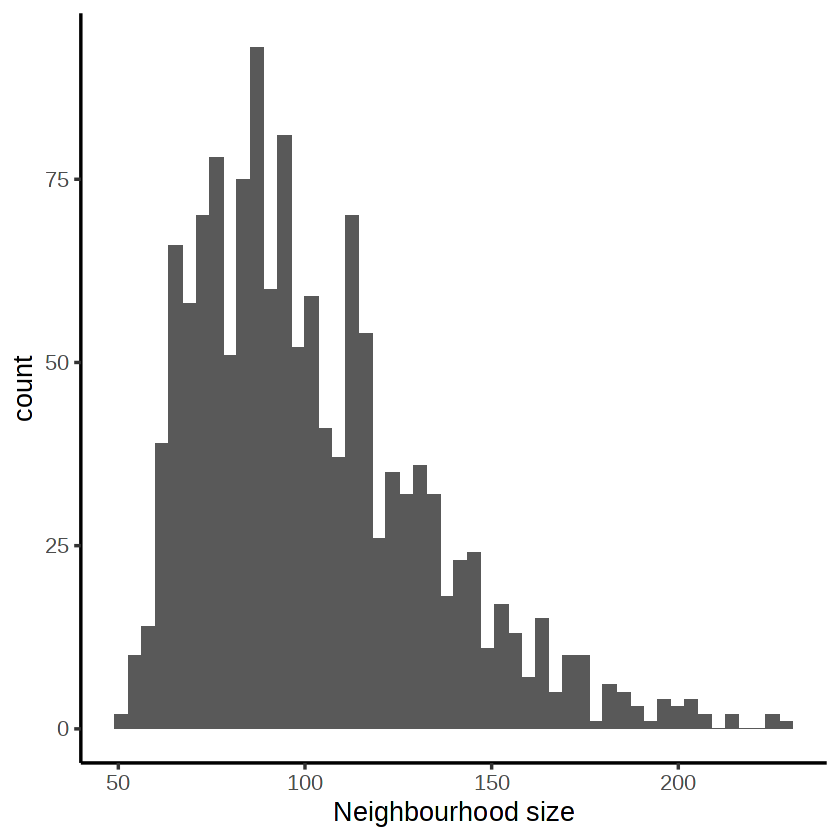

In [16]:
plotNhoodSizeHist(sce_milo)

In [17]:
sce_milo <- countCells(sce_milo, meta.data = data.frame(colData(sce_milo)), sample="sample")

Checking meta.data validity

Counting cells in neighbourhoods



In [18]:
head(nhoodCounts(sce_milo))

6 x 8 sparse Matrix of class "dgCMatrix"
  HD_F_GON15290542 HD_F_GON15290543 HD_F_GON15290547 HD_F_GON15290548
1                8                9               19               25
2                .                .                1                1
3                1                1               37               16
4                .                .                .                1
5               18                4               25               15
6                .                3               24               19
  HD_F_GON15290552 HD_F_GON15290556 HD_F_GON15290557 HD_F_GON15290559
1               47               22               54                4
2               17               29               63               36
3               12               11                7                .
4               31               53               56               33
5                1                2                2                1
6               27               12              

In [19]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:matrixStats’:

    count


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, u

In [20]:
sce_design <- data.frame(colData(sce_milo))[,c("sample", "condition")]
## Convert batch info from integer to factor
sce_design <- distinct(sce_design)
rownames(sce_design) <- sce_design$sample

sce_design

,sample,condition
,<fct>,<fct>
HD_F_GON15290542,HD_F_GON15290542,ctrl_dmso
HD_F_GON15290543,HD_F_GON15290543,BPA
HD_F_GON15290547,HD_F_GON15290547,ctrl_dmso
HD_F_GON15290548,HD_F_GON15290548,BPA
HD_F_GON15290552,HD_F_GON15290552,ctrl_dmso
HD_F_GON15290556,HD_F_GON15290556,ctrl_dmso
HD_F_GON15290557,HD_F_GON15290557,BPA
HD_F_GON15290559,HD_F_GON15290559,BPA


In [21]:
sce_milo <- calcNhoodDistance(sce_milo, d=14, reduced.dim = "X_pca_harmony")

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



In [22]:
da_results <- testNhoods(sce_milo, design = ~condition, design.df = sce_design)

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



In [23]:
da_results %>%
  arrange(SpatialFDR) %>%
  head()

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,8.284279,10.239421,36.40637,0.0003072917,0.01625871,18,0.01673729
19,8.523151,10.463994,43.96247,0.0001616098,0.01625871,19,0.01673729
42,7.959447,9.951703,41.14514,0.0002029376,0.01625871,42,0.01673729
74,8.496651,10.437078,41.38337,0.0001989661,0.01625871,74,0.01673729
76,7.653013,9.680984,38.17490,0.0002618790,0.01625871,76,0.01673729
81,7.646027,9.676030,36.26553,0.0003113170,0.01625871,81,0.01673729


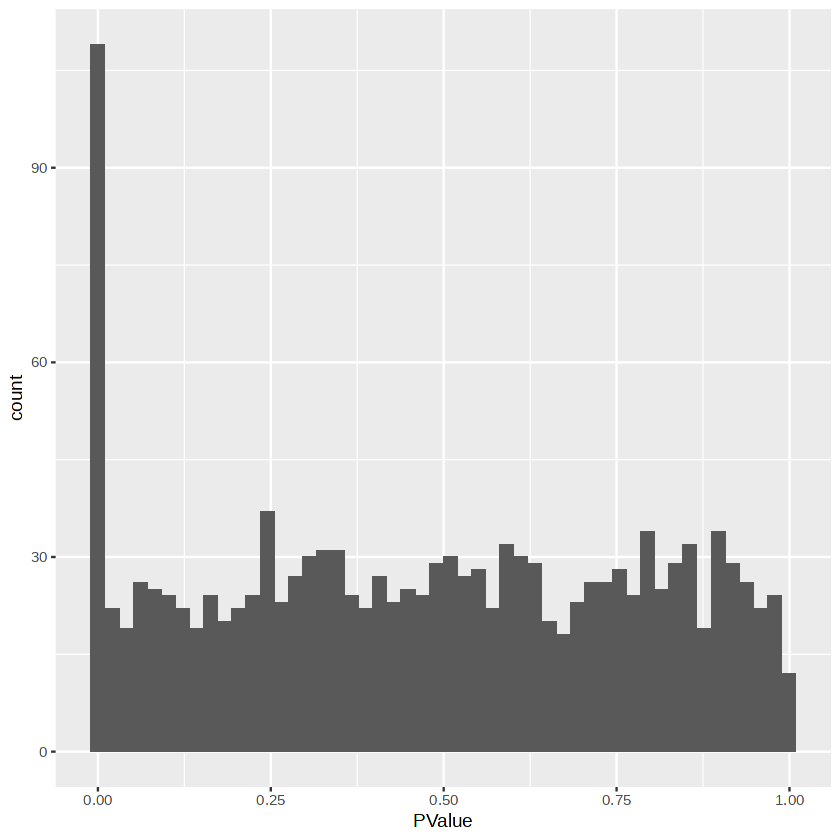

In [24]:
ggplot(da_results, aes(PValue)) + geom_histogram(bins=50)

In [25]:
library(patchwork)


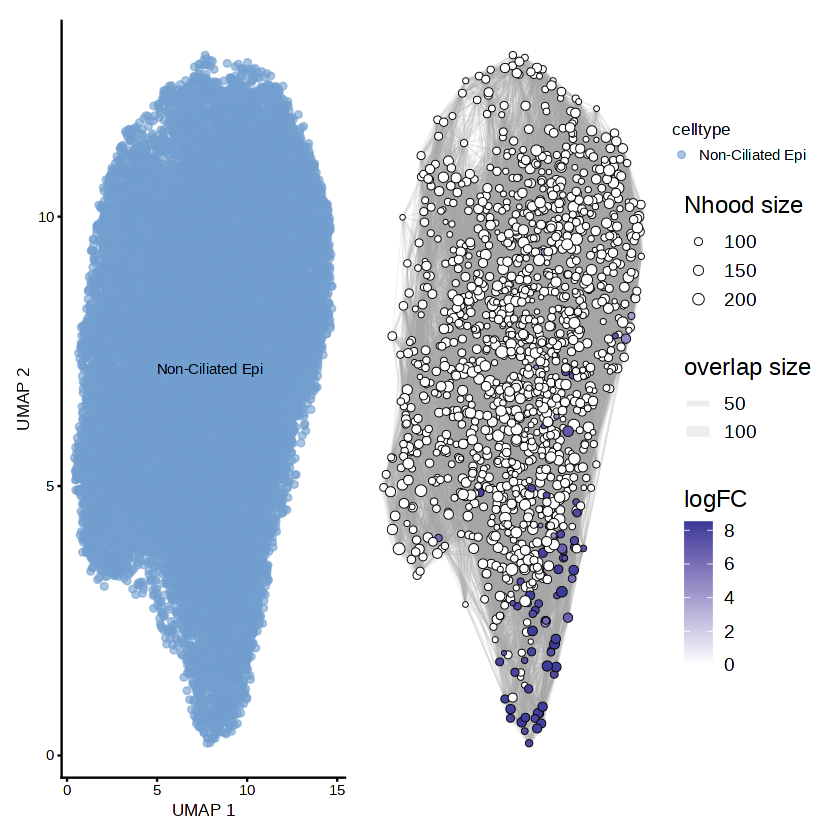

In [26]:
sce_milo <- buildNhoodGraph(sce_milo)

## Plot single-cell UMAP
umap_pl <- plotReducedDim(sce_milo, dimred = "UMAP", colour_by="celltype",
                          text_by = "celltype", text_size = 3) +
  guides(fill="none")

## Plot neighbourhood graph
nh_graph_pl <- plotNhoodGraphDA(sce_milo, da_results, layout = "UMAP", alpha = 0.05) +
  scale_color_gradientn(
    colors = c("white", "green"),  # Define a custom gradient (low to high logFC)
  )

umap_pl + nh_graph_pl +
  plot_layout(guides="collect")

In [27]:
# Open a PDF file to save the plot with specified width and height
pdf("nh_graph_bpa_g1.pdf", width=8, height=6)  # Width and height are in inches

# Create your plot. Assuming nh_graph_pl is the plot object
print(nh_graph_pl)

# Close the device to save the file
dev.off()

pdf 
  2

In [28]:
2+3

[1] 5

In [29]:
da_results <- annotateNhoods(sce_milo, da_results, coldata_col = "leiden")
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,leiden,leiden_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,0.09725891,10.493606,0.01007767,0.9218385,0.9863932,1,0.9876323,0,0.9680851
2,1.46615627,10.457762,0.71548911,0.4162013,0.9296076,2,0.9430171,3,1.0000000
3,-1.18356277,9.362644,0.98712153,0.3424529,0.8951667,3,0.9094081,0,1.0000000
4,0.47589541,10.636262,0.06600241,0.8021372,0.9843128,4,0.9860046,3,1.0000000
5,-0.79392990,9.079929,0.58174224,0.4621661,0.9427213,5,0.9543521,1,0.7647059
6,-0.55193328,9.646682,0.23951358,0.6344669,0.9589724,6,0.9654901,3,0.9600000


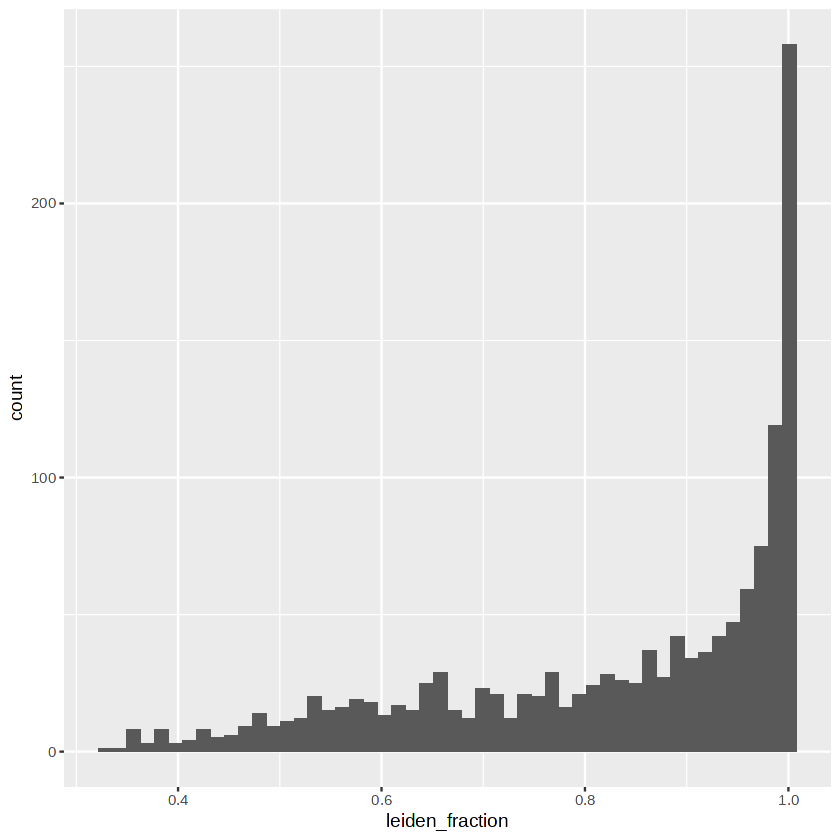

In [30]:
ggplot(da_results, aes(leiden_fraction)) + geom_histogram(bins=50)

Converting group.by to factor...



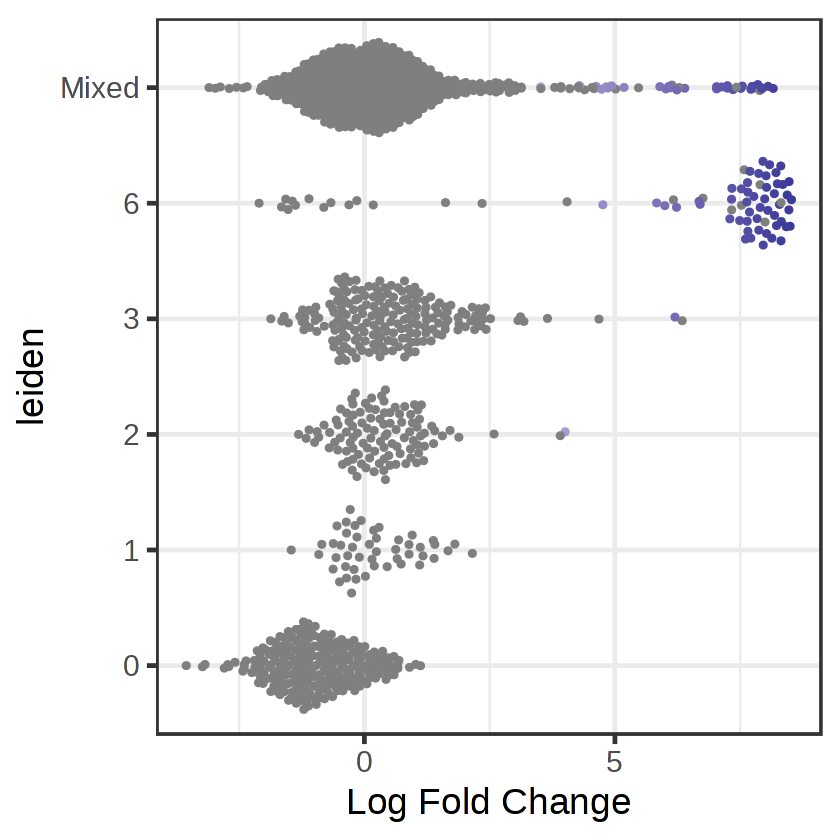

In [31]:
da_results$leiden <- ifelse(da_results$leiden_fraction < 0.9, "Mixed", da_results$leiden)
plotDAbeeswarm(da_results, group.by = "leiden", alpha = 0.05)

In [32]:
da_results$NhoodGroup <- as.numeric(da_results$SpatialFDR < 0.05 & da_results$logFC > 1)

In [33]:
table(da_results$NhoodGroup, da_results$leiden)

   
      0   1   2   3   6 Mixed
  0 238  48 106 199  23   663
  1   0   0   1   1  50    29

In [34]:
da_nhood_markers <- findNhoodGroupMarkers(sce_milo, da_results, 
                                          aggregate.samples = TRUE, sample_col = "sample")

Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message:
“Zero sample variances detected, have been offset away from zero”


In [35]:
library(ggrepel)


Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


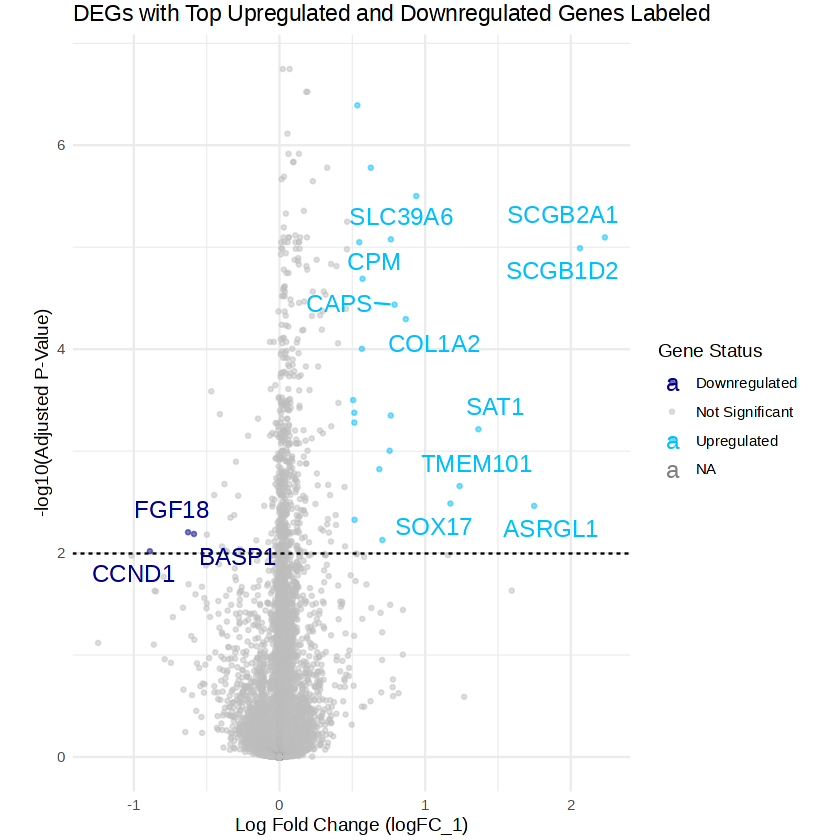

In [48]:
# Add a column to classify points based on the criteria
da_nhood_markers$highlight <- ifelse(
  da_nhood_markers$logFC_1 > 0.5 & da_nhood_markers$adj.P.Val_1 < 0.01, 
  "Upregulated",
  ifelse(
    da_nhood_markers$logFC_1 < -0.5 & da_nhood_markers$adj.P.Val_1 < 0.01, 
    "Downregulated", 
    "Not Significant"
  )
)

# Identify top 10 upregulated and top 10 downregulated genes
top_upregulated <- da_nhood_markers[da_nhood_markers$highlight == "Upregulated", ]
top_upregulated <- top_upregulated[order(-top_upregulated$logFC_1), ][1:10, ]

top_downregulated <- da_nhood_markers[da_nhood_markers$highlight == "Downregulated", ]
top_downregulated <- top_downregulated[order(top_downregulated$logFC_1), ][1:10, ]

# Combine the top genes for labeling
top_genes <- rbind(top_upregulated, top_downregulated)

# Create the plot
ggplot(da_nhood_markers, aes(x = logFC_1, y = -log10(adj.P.Val_1), color = highlight)) + 
  geom_point(alpha = 0.5, size = 0.8) + 
  geom_hline(yintercept = 2, color = "black", linetype = "dashed") +
  geom_text_repel(
    data = top_genes,  # Use only the top genes for labeling
    aes(label = GeneID),
    size = 5,
    box.padding = 0.5, # Padding around labels
    point.padding = 0.3 # Padding between points and labels
  ) +
  scale_color_manual(values = c(
    "Upregulated" = "deepskyblue", 
    "Downregulated" = "darkblue", 
    "Not Significant" = "grey"
  )) +
  coord_fixed(ratio = 0.7) + # Set the desired aspect ratio
  theme_minimal() +
  theme(
    plot.margin = unit(c(0.1, 0.1, 0.1, 0.1), "cm"), # Adjust margins: top, right, bottom, left
    panel.spacing = unit(0, "lines")                # Remove internal padding
  ) +
  labs(
    title = "DEGs with Top Upregulated and Downregulated Genes Labeled",
    x = "Log Fold Change (logFC_1)",
    y = "-log10(Adjusted P-Value)",
    color = "Gene Status"
  )
# Save the plot as a PDF with specified dimensions
ggsave("top_genes_plot_BPA.pdf", width = 10, height = 6, dpi = 300)

In [36]:
head(da_nhood_markers)

,logFC_0,adj.P.Val_0,logFC_1,adj.P.Val_1,GeneID
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SELENOP,-0.6130873,9.212609e-08,0.6130873,9.212609e-08,SELENOP
ATP6V1C2,-0.2093502,1.642002e-07,0.2093502,1.642002e-07,ATP6V1C2
NRIP1,-0.5703959,4.406228e-07,0.5703959,4.406228e-07,NRIP1
LINC00937,-0.1061748,6.057514e-07,0.1061748,6.057514e-07,LINC00937
CD200,-0.5390036,6.057514e-07,0.5390036,6.057514e-07,CD200
PGR,-0.5711039,6.464057e-07,0.5711039,6.464057e-07,PGR


In [37]:
write.csv(da_nhood_markers, paste0(human_dir, "organoids_BPA_g1_DEGs.csv"))

In [38]:
markers_up <- da_nhood_markers$GeneID[da_nhood_markers$adj.P.Val_1 < 0.05 & da_nhood_markers$logFC_1 > 0.5]

In [1]:
length(markers_up)

ERROR: Error: object 'markers_up' not found


In [40]:
markers_up

[1] "SELENOP"  "NRIP1"    "CD200"    "PGR"      "SOX17"    "C2orf88" 
 [7] "SCGB2A1"  "RBBP7"    "SLC39A6"  "CADM1"    "CPM"      "CAPS"    
[13] "GUCY1B1"  "CCDC146"  "ESR1"     "CITED4"   "SCGB1D2"  "KIAA1324"
[19] "CLDN10"   "SAT1"     "PSAT1"    "MPST"     "DEPTOR"   "ASRGL1"  
[25] "STX18"    "COL1A2"   "KLK11"    "TMEM101"  "CST3"     "EYA2"    
[31] "ALPL"     "LRIG1"    "LGR5"     "PIR"      "CERNA2"   "RNASET2" 
[37] "SERPINA1" "MMP7"     "COL18A1"  "TFF3"     "RESF1"    "VIM"     
[43] "ITIH5"    "ID4"

In [41]:
library(enrichR)


Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is available!

WormEnrichr ... 
Connection is available!

YeastEnrichr ... 
Connection is available!

FishEnrichr ... 
Connection is available!



In [42]:
2+3

[1] 5

In [43]:
# Specify the databases to use
selected_dbs <- c("KEGG_2021_Human", "GO_Biological_Process_2021", "MSigDB_Hallmark_2020")

# Perform enrichment analysis
enrichment_results <- enrichR::enrichr(markers_up, selected_dbs)

Uploading data to Enrichr... Done.
  Querying KEGG_2021_Human... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.


In [44]:
# View results for the KEGG database
kegg_results <- enrichment_results[["KEGG_2021_Human"]]
head(kegg_results)

# View results for the GO Biological Process database
go_results <- enrichment_results[["GO_Biological_Process_2021"]]
head(go_results)

# View results for the GO Biological Process database
msigdb_results <- enrichment_results[["MSigDB_Hallmark_2020"]]
head(msigdb_results)

,Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
1,Cysteine and methionine metabolism,2/50,0.005418766,0.1593660,0,0,19.750000,103.05327,MPST;PSAT1
2,Wnt signaling pathway,3/166,0.005795126,0.1593660,0,0,8.885082,45.76473,MMP7;SOX17;LGR5
3,Vitamin B6 metabolism,1/6,0.013129125,0.1711928,0,0,92.795349,402.07503,PSAT1
4,Sulfur relay system,1/8,0.017467967,0.1711928,0,0,66.275748,268.24357,MPST
5,Salivary secretion,2/93,0.017827712,0.1711928,0,0,10.395081,41.86100,CST3;GUCY1B1
6,Protein digestion and absorption,2/103,0.021590355,0.1711928,0,0,9.361150,35.90477,COL18A1;COL1A2


,Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
1,intracellular steroid hormone receptor signaling pathway (GO:0030518),3/44,0.0001235322,0.04484220,0,0,35.541344,319.83686,SCGB2A1;PGR;ESR1
2,steroid hormone mediated signaling pathway (GO:0043401),2/15,0.0004877036,0.08851821,0,0,73.051282,557.07466,PGR;ESR1
3,cellular response to estradiol stimulus (GO:0071392),2/21,0.0009672636,0.11703889,0,0,49.967419,346.82583,NRIP1;ESR1
4,response to estrogen (GO:0043627),2/35,0.0026875485,0.12830316,0,0,28.748918,170.16846,CITED4;ESR1
5,response to estradiol (GO:0032355),2/38,0.0031621188,0.12830316,0,0,26.349206,151.67955,NRIP1;ESR1
6,cellular response to oxygen-containing compound (GO:1901701),4/323,0.0054524500,0.12830316,0,0,6.155799,32.08212,GUCY1B1;NRIP1;VIM;ESR1


,Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
1,Estrogen Response Early,6/200,4.771806e-06,0.0000906643,0,0,16.084102,197.07506,DEPTOR;NRIP1;SLC39A6;LRIG1;TFF3;PGR
2,Estrogen Response Late,5/200,7.524121e-05,0.0007147915,0,0,12.992110,123.35764,SERPINA1;NRIP1;TFF3;PGR;KLK11
3,Epithelial Mesenchymal Transition,4/200,9.633623e-04,0.0061012946,0,0,10.081633,70.01776,COL1A2;CADM1;VIM;SAT1
4,IL-2/STAT5 Signaling,3/199,9.524092e-03,0.0452394388,0,0,7.376804,34.33114,ITIH5;GUCY1B1;LRIG1
5,Androgen Response,2/100,2.042948e-02,0.0776320387,0,0,9.649174,37.54278,SELENOP;SAT1
6,Coagulation,2/138,3.702399e-02,0.1172426454,0,0,6.939776,22.87481,SERPINA1;MMP7


In [45]:
# Filter results with adjusted p-value < 0.05
filtered_kegg <- kegg_results[kegg_results$Adjusted.P.value < 0.05, ]
filtered_go <- go_results[go_results$Adjusted.P.value < 0.05, ]
filtered_msigdb <- msigdb_results[msigdb_results$Adjusted.P.value < 0.05, ]

In [46]:
filtered_msigdb

,Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
1,Estrogen Response Early,6/200,4.771806e-06,0.0000906643,0,0,16.084102,197.07506,DEPTOR;NRIP1;SLC39A6;LRIG1;TFF3;PGR
2,Estrogen Response Late,5/200,7.524121e-05,0.0007147915,0,0,12.992110,123.35764,SERPINA1;NRIP1;TFF3;PGR;KLK11
3,Epithelial Mesenchymal Transition,4/200,9.633623e-04,0.0061012946,0,0,10.081633,70.01776,COL1A2;CADM1;VIM;SAT1
4,IL-2/STAT5 Signaling,3/199,9.524092e-03,0.0452394388,0,0,7.376804,34.33114,ITIH5;GUCY1B1;LRIG1


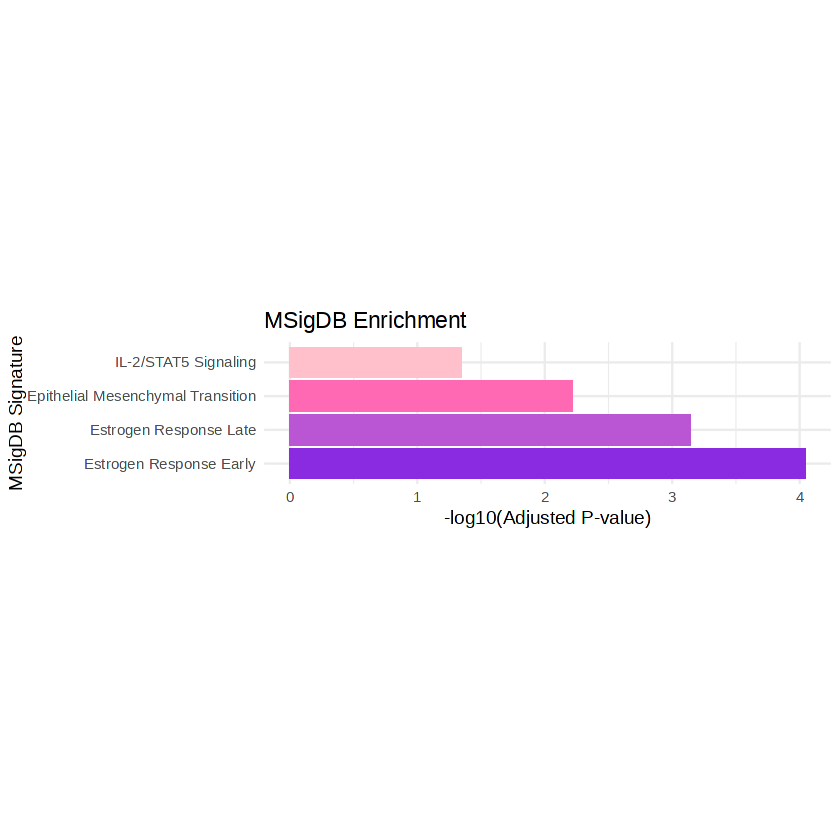

In [53]:
# Subset data to include only the top 5 GO terms by adjusted p-value
top_go_terms <- filtered_msigdb[order(filtered_msigdb$Adjusted.P.value), ][1:4, ]

# Generate a palette of blue shades for the bars
blue_shades <- c( "hotpink", "blueviolet", "mediumorchid", "pink")  # Custom blue shades

# Create the bar plot for the top 5 GO terms
ggplot(top_go_terms, aes(x = reorder(Term, Adjusted.P.value), y = -log10(Adjusted.P.value), fill = Term)) +
  geom_bar(stat = "identity") +
  coord_flip() +  # Flips the coordinates for a horizontal bar plot
  scale_fill_manual(values = blue_shades) +  # Apply custom blue shades
  labs(
    title = "MSigDB Enrichment",
    x = "MSigDB Signature",
    y = "-log10(Adjusted P-value)"
  ) +
  theme_minimal() +
  theme(
    aspect.ratio = 1/4,
    legend.position = "none"  # Remove legend
  )
# Save the plot as a PDF with specified dimensions
ggsave("GO_BPA.pdf", width = 10, height = 6, dpi = 300)